# Libary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.linalg import toeplitz
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the Data

In [2]:
# Load the Longley dataset
data = sm.datasets.longley.load()
df = data.data

# Display the data
display(df.head())

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,60323.0,83.0,234289.0,2356.0,1590.0,107608.0,1947.0
1,61122.0,88.5,259426.0,2325.0,1456.0,108632.0,1948.0
2,60171.0,88.2,258054.0,3682.0,1616.0,109773.0,1949.0
3,61187.0,89.5,284599.0,3351.0,1650.0,110929.0,1950.0
4,63221.0,96.2,328975.0,2099.0,3099.0,112075.0,1951.0


# Explore the Data

In [3]:
# Dataset information
print("Dataset Information:")
print(df.info())

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Statistical summary
print("\nStatistical Summary:")
display(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TOTEMP   16 non-null     float64
 1   GNPDEFL  16 non-null     float64
 2   GNP      16 non-null     float64
 3   UNEMP    16 non-null     float64
 4   ARMED    16 non-null     float64
 5   POP      16 non-null     float64
 6   YEAR     16 non-null     float64
dtypes: float64(7)
memory usage: 1.0 KB
None

Missing Values in Each Column:
TOTEMP     0
GNPDEFL    0
GNP        0
UNEMP      0
ARMED      0
POP        0
YEAR       0
dtype: int64

Statistical Summary:


,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,65317.000000,101.681250,387698.437500,3193.312500,2606.687500,117424.000000,1954.500000
std,3511.968356,10.791553,99394.937795,934.464247,695.919604,6956.101561,4.760952
min,60171.000000,83.000000,234289.000000,1870.000000,1456.000000,107608.000000,1947.000000
25%,62712.500000,94.525000,317881.000000,2348.250000,2298.000000,111788.500000,1950.750000
50%,65504.000000,100.600000,381427.000000,3143.500000,2717.500000,116803.500000,1954.500000
75%,68290.500000,111.250000,454085.500000,3842.500000,3060.750000,122304.000000,1958.250000
max,70551.000000,116.900000,554894.000000,4806.000000,3594.000000,130081.000000,1962.000000


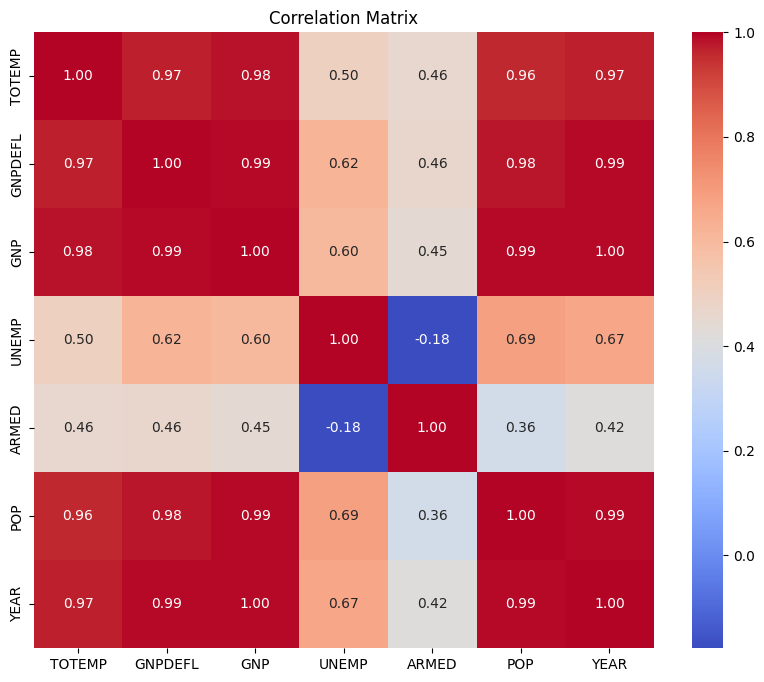

In [4]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

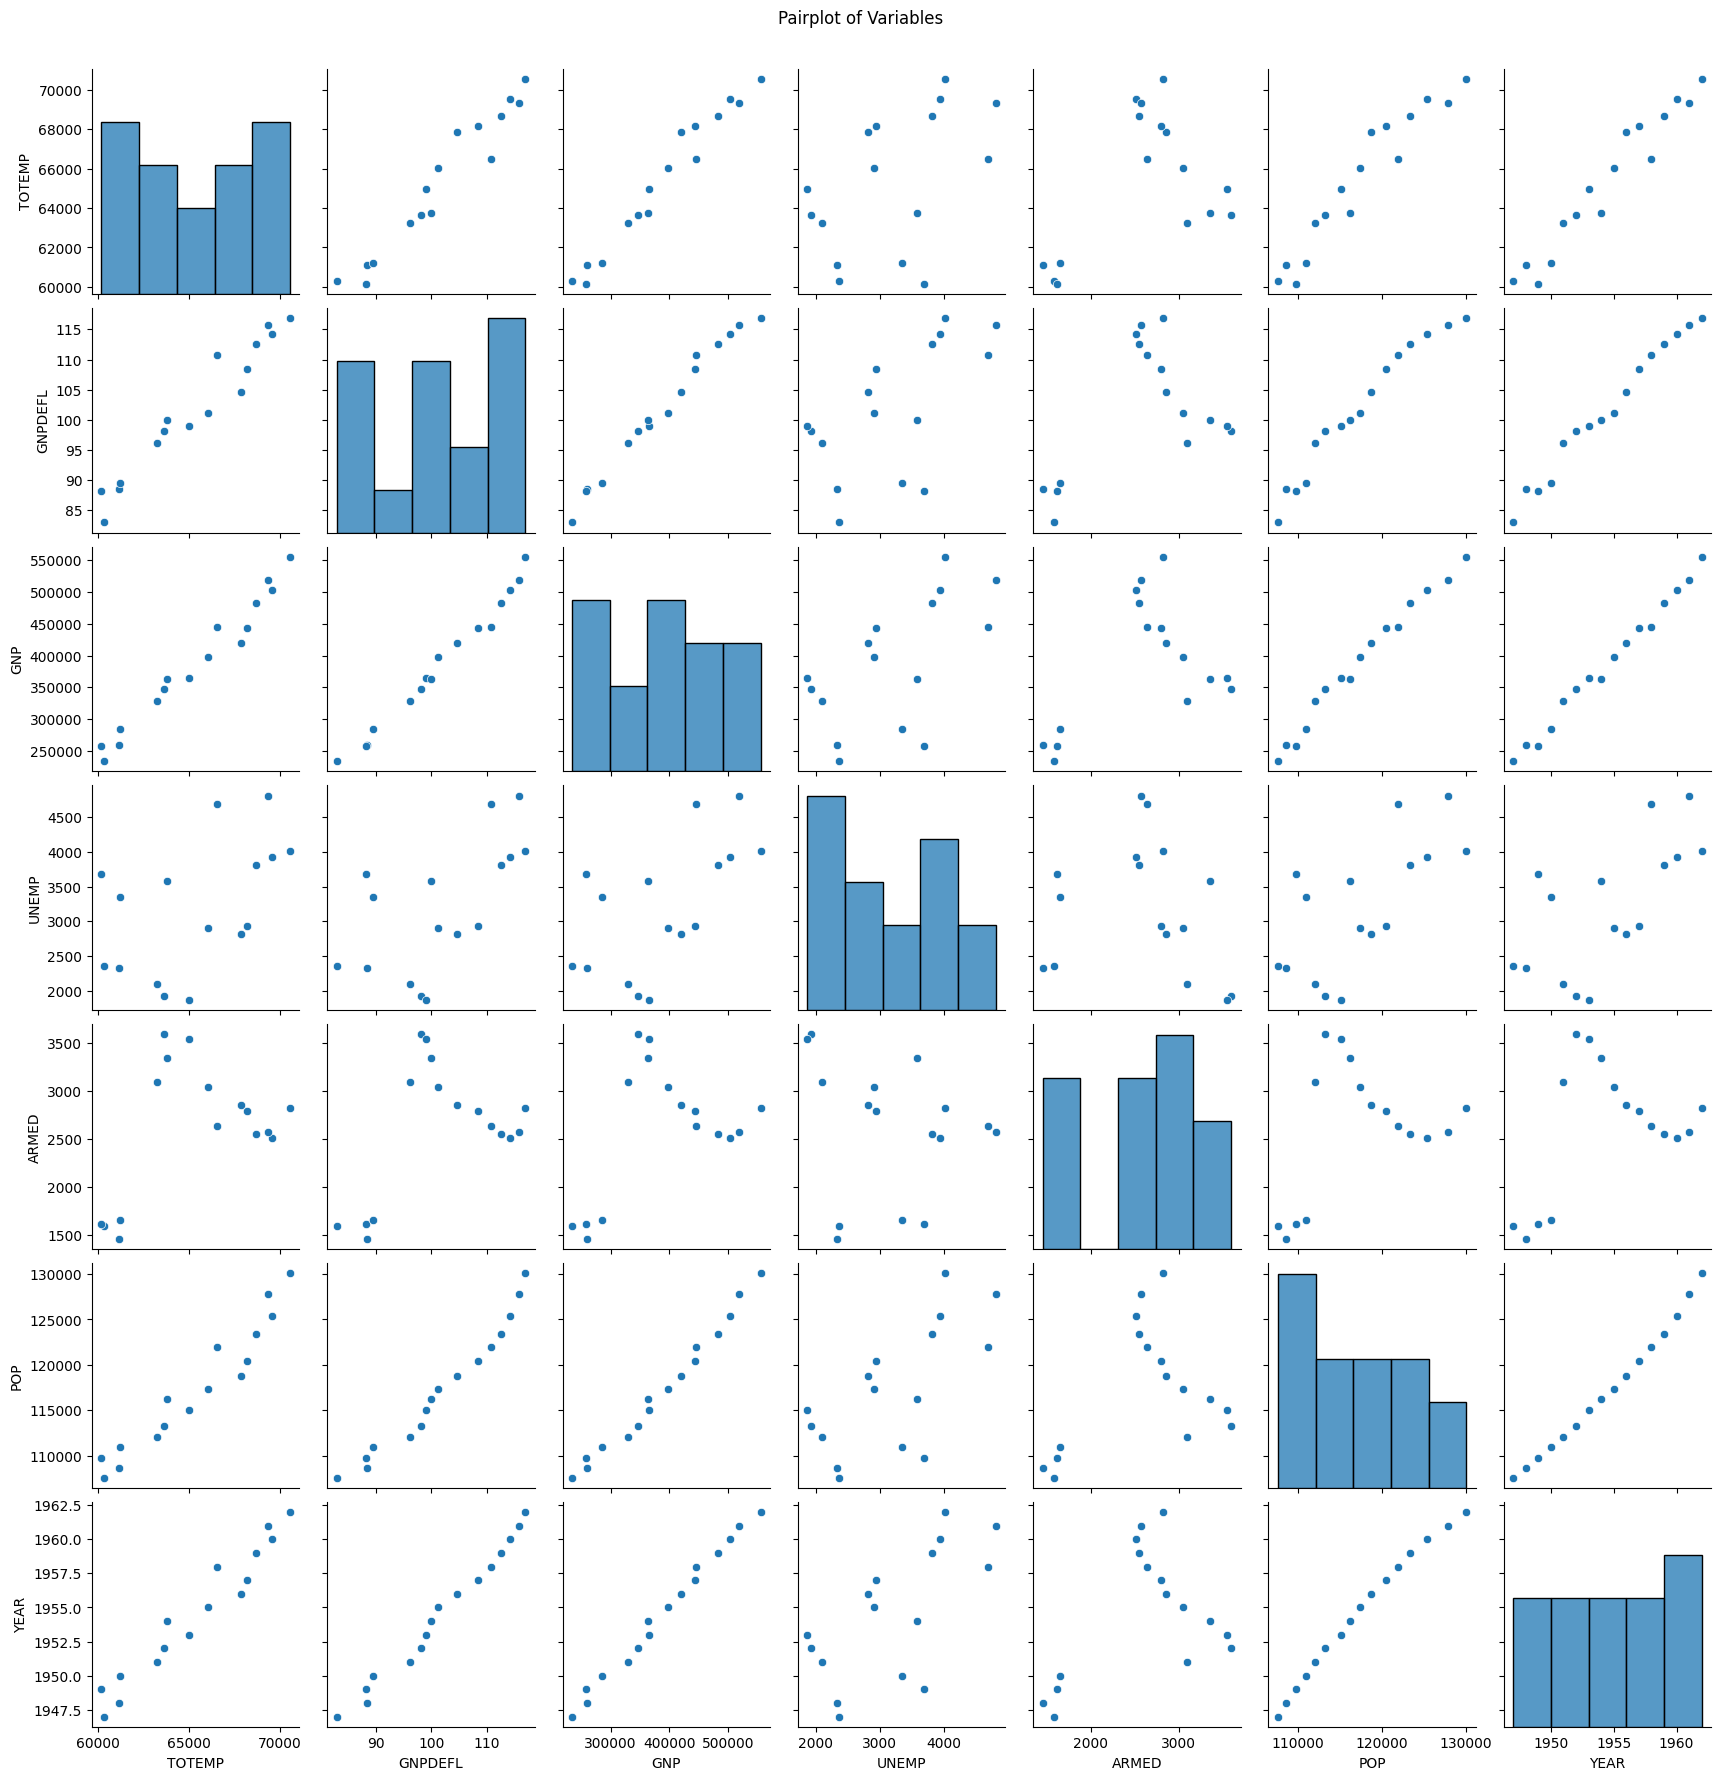

In [5]:
# Pairplot to visualize relationships
sns.pairplot(df)
plt.suptitle('Pairplot of Variables', y=1.02)
plt.show()

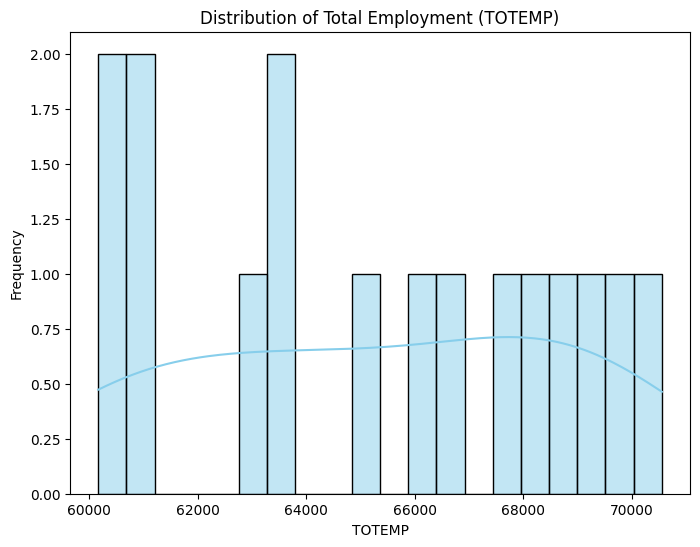

In [6]:
# Distribution of the dependent variable (TOTEMP)
plt.figure(figsize=(8, 6))
sns.histplot(df['TOTEMP'], kde=True, bins=20, color='skyblue')
plt.title('Distribution of Total Employment (TOTEMP)')
plt.xlabel('TOTEMP')
plt.ylabel('Frequency')
plt.show()

# Prepare the Data

In [7]:
# Define dependent variable (y) and independent variables (X)
y = df['TOTEMP']
X = df.drop(['TOTEMP'], axis=1)

In [8]:
# Add a constant term to the independent variables
X = sm.add_constant(X)

In [9]:
# Display independent variables
print("Independent Variables (X):")
display(X.head())

# Display dependent variable
print("\nDependent Variable (y):")
display(y.head())

Independent Variables (X):


,const,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,1.0,83.0,234289.0,2356.0,1590.0,107608.0,1947.0
1,1.0,88.5,259426.0,2325.0,1456.0,108632.0,1948.0
2,1.0,88.2,258054.0,3682.0,1616.0,109773.0,1949.0
3,1.0,89.5,284599.0,3351.0,1650.0,110929.0,1950.0
4,1.0,96.2,328975.0,2099.0,3099.0,112075.0,1951.0



Dependent Variable (y):


,TOTEMP
0,60323.0
1,61122.0
2,60171.0
3,61187.0
4,63221.0


# Create the Models

In [10]:
# 1. Ordinary Least Squares (OLS)
ols_model = sm.OLS(y, X).fit()

In [11]:
# 2. Weighted Least Squares (WLS)
# For demonstration, use weights as inverse of squared OLS residuals
weights = 1 / (ols_model.resid ** 2 + 1e-6)  # Add small constant to avoid division by zero
wls_model = sm.WLS(y, X, weights=weights).fit()

In [12]:
# 3. Generalized Least Squares (GLS)
# Assuming an AR(1) covariance structure with known rho (rho = 0.5)
rho_gls = 0.5
n = len(y)
order = np.abs(np.subtract.outer(np.arange(n), np.arange(n)))
sigma_gls = rho_gls ** order
gls_model = sm.GLS(y, X, sigma=sigma_gls).fit()

In [13]:
# 4. Feasible Generalized Least Squares (FGLS)
# Iteratively estimate rho and fit GLS
fgls_iterations = 5
fgls_results = ols_model

for i in range(fgls_iterations):
    # Obtain residuals from the current model
    resid = fgls_results.resid

    # Regress residuals on lagged residuals to estimate rho
    resid_lagged = sm.add_constant(resid.shift(1).dropna())
    resid_current = resid.iloc[1:]
    resid_fit = sm.OLS(resid_current, resid_lagged).fit()

    # Access rho_est using .iloc
    rho_est = resid_fit.params.iloc[1]

    # Constrain rho_est within (-0.99, 0.99) to ensure positive definiteness
    rho_est = max(min(rho_est, 0.99), -0.99)

    # Construct covariance matrix assuming AR(1) structure
    sigma_fgls = rho_est ** np.abs(np.subtract.outer(np.arange(n), np.arange(n)))

    # Fit GLS model with the estimated covariance matrix
    gls_fgls = sm.GLS(y, X, sigma=sigma_fgls).fit()
    fgls_results = gls_fgls

In [14]:
# 5. Generalized Least Squares with Autoregressive Errors (GLSAR)
# Using order=1 for AR(1)
glsar_model = sm.GLSAR(y, X, rho=1)
glsar_results = glsar_model.iterative_fit(maxiter=10)

# Evaluate the Models

In [15]:
# Display model summaries
print("===== Ordinary Least Squares (OLS) Summary =====")
print(ols_model.summary())

print("\n\n\n===== Weighted Least Squares (WLS) Summary =====")
print(wls_model.summary())

print("\n\n\n===== Generalized Least Squares (GLS) Summary =====")
print(gls_model.summary())

print("\n\n\n===== Feasible Generalized Least Squares (FGLS) Summary =====")
print(fgls_results.summary())

print("\n\n\n===== GLS with Autoregressive Errors (GLSAR) Summary =====")
print(glsar_results.summary())

===== Ordinary Least Squares (OLS) Summary =====
                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           4.98e-10
Time:                        06:39:32   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [16]:
# Goodness of fit and information criteria metrics
metrics = pd.DataFrame({
    'Model': ['OLS', 'WLS', 'GLS', 'FGLS', 'GLSAR'],
    'R-squared': [
        ols_model.rsquared,
        wls_model.rsquared,
        gls_model.rsquared,
        fgls_results.rsquared,
        glsar_results.rsquared
    ],
    'Adjusted R-squared': [
        ols_model.rsquared_adj,
        wls_model.rsquared_adj,
        gls_model.rsquared_adj,
        fgls_results.rsquared_adj,
        glsar_results.rsquared_adj
    ],
    'AIC': [
        ols_model.aic,
        wls_model.aic,
        gls_model.aic,
        fgls_results.aic,
        glsar_results.aic
    ],
    'BIC': [
        ols_model.bic,
        wls_model.bic,
        gls_model.bic,
        fgls_results.bic,
        glsar_results.bic
    ]
})

print("Goodness of Fit and Information Criteria Metrics:")
display(metrics)

Goodness of Fit and Information Criteria Metrics:


,Model,R-squared,Adjusted R-squared,AIC,BIC
0,OLS,0.995479,0.992465,233.234870,238.642991
1,WLS,0.999860,0.999767,199.533879,204.942000
2,GLS,0.984246,0.973743,238.744168,244.152289
3,FGLS,0.998933,0.998221,226.306259,231.714380
4,GLSAR,0.998857,0.998000,212.802726,217.759077


In [17]:
def plot_residuals(model, model_name):
    residuals = model.resid
    fitted = model.fittedvalues

    # Residuals vs. fitted
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted for {model_name}')
    plt.show()

    # Q-Q plot
    sm.qqplot(residuals, line='45', fit=True)
    plt.title(f'Q-Q Plot for {model_name}')
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=15, color='salmon')
    plt.title(f'Histogram of Residuals for {model_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

=== Residual Diagnostics for OLS ===


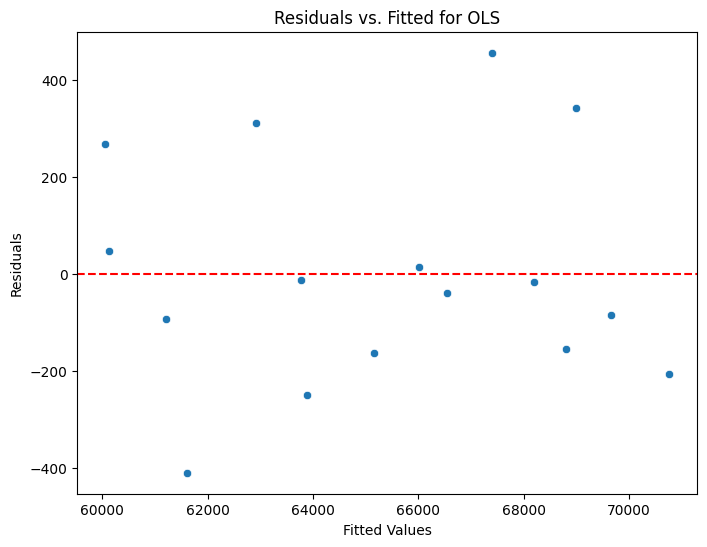

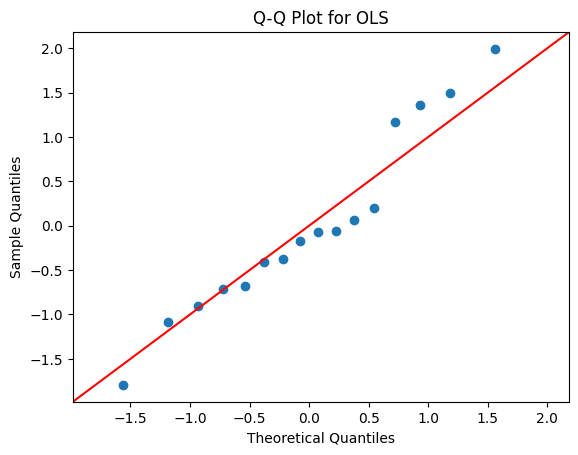

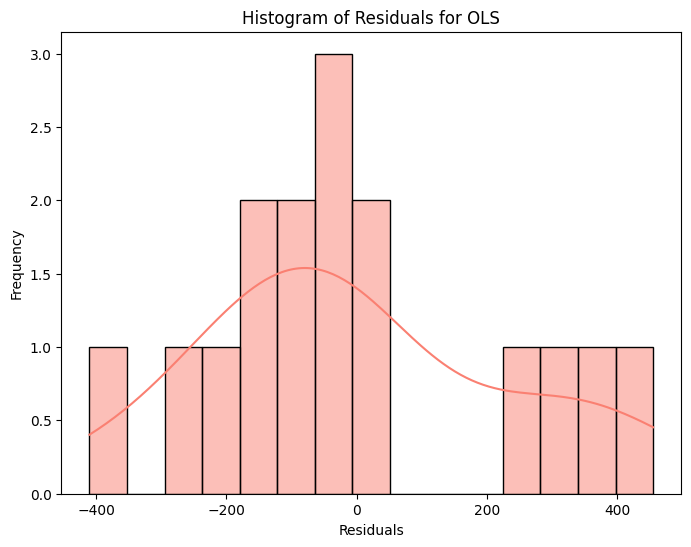





=== Residual Diagnostics for WLS ===


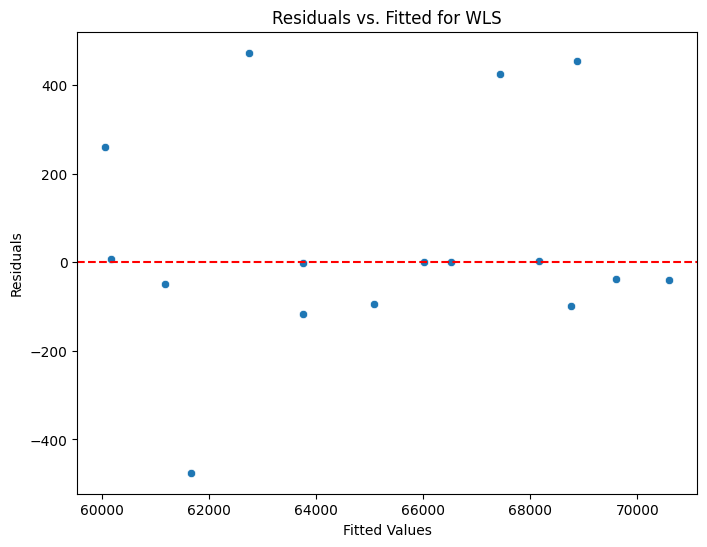

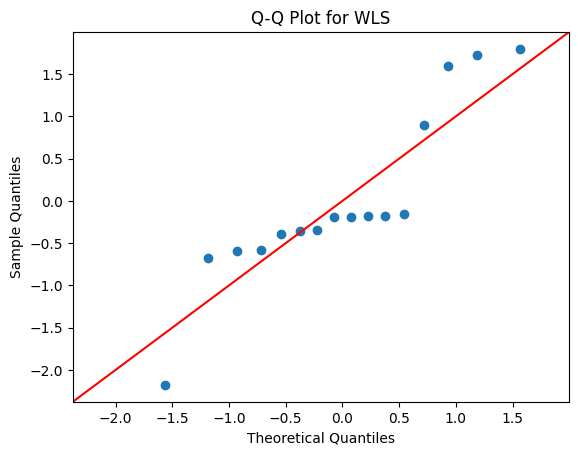

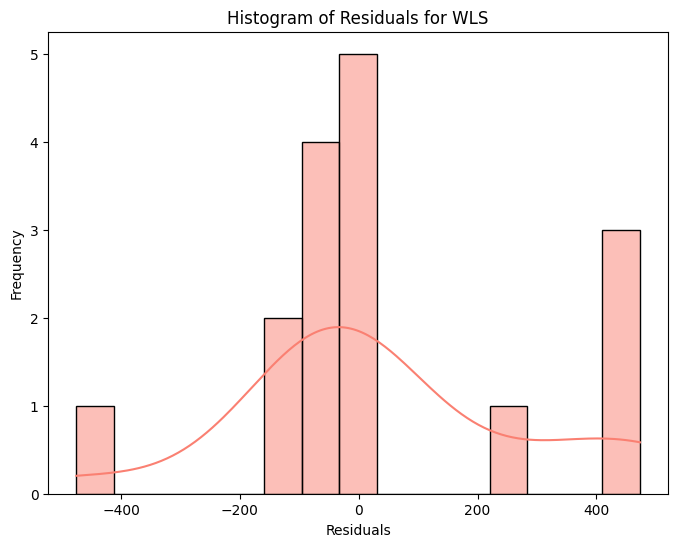





=== Residual Diagnostics for GLS ===


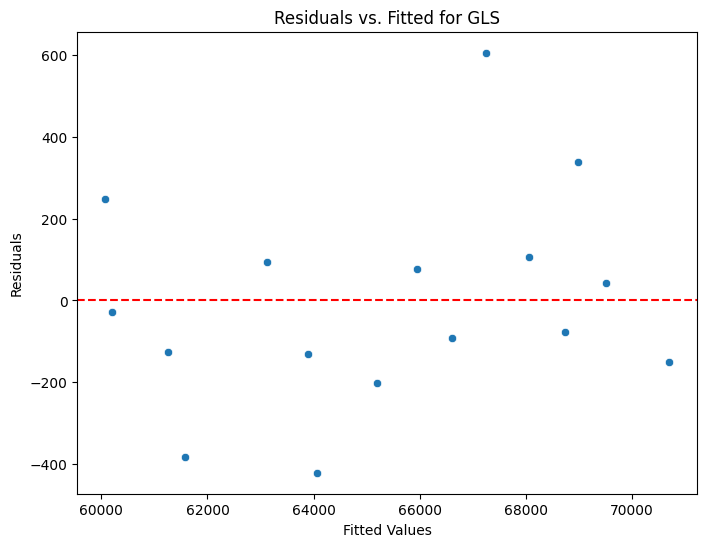

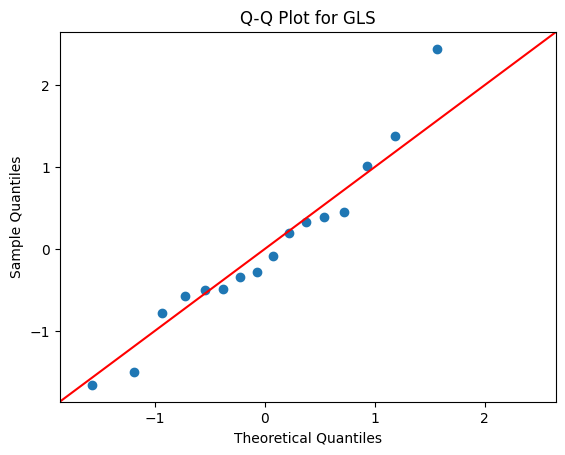

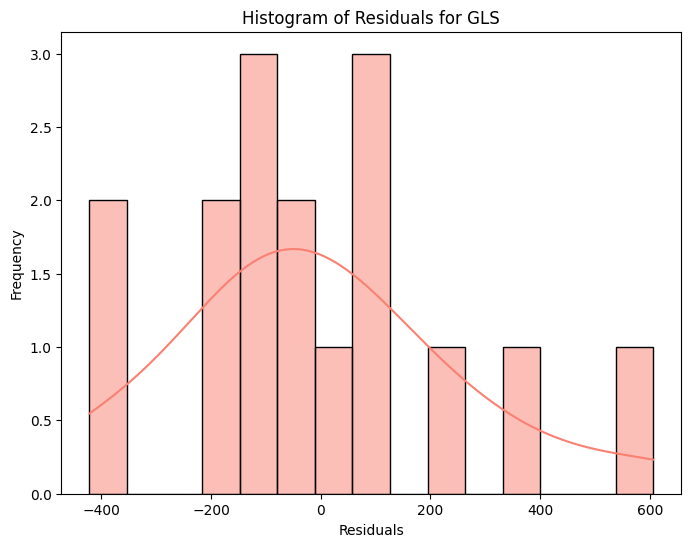





=== Residual Diagnostics for FGLS ===


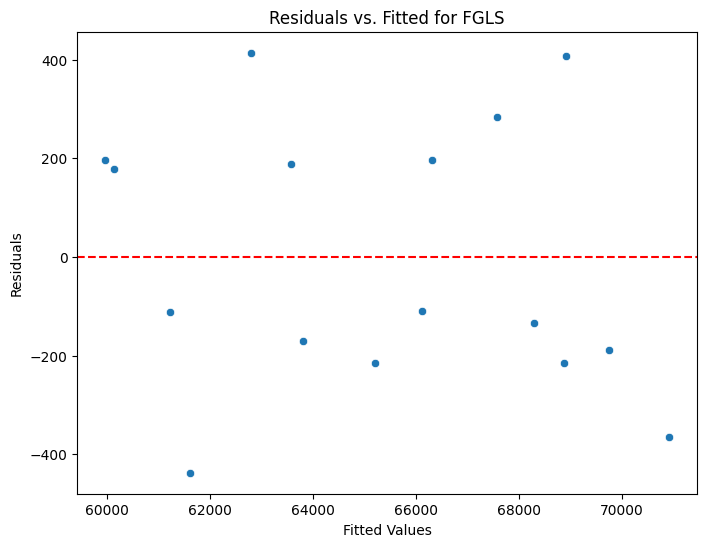

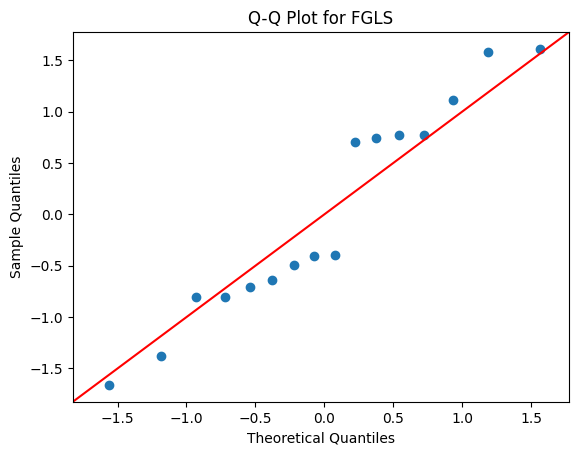

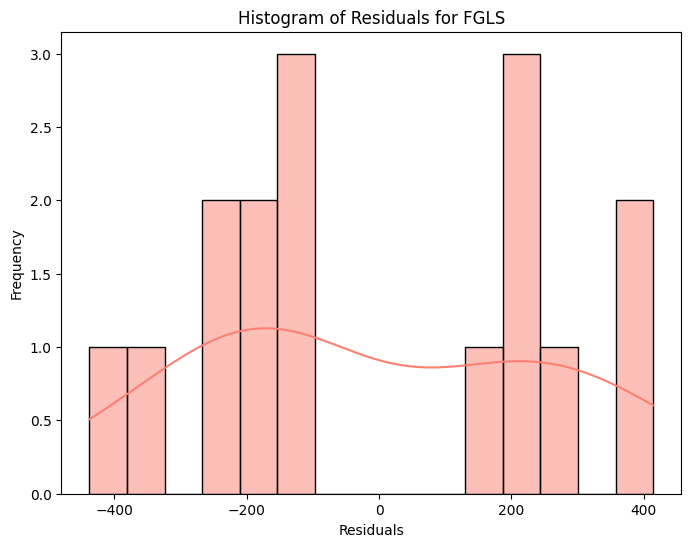





=== Residual Diagnostics for GLSAR ===


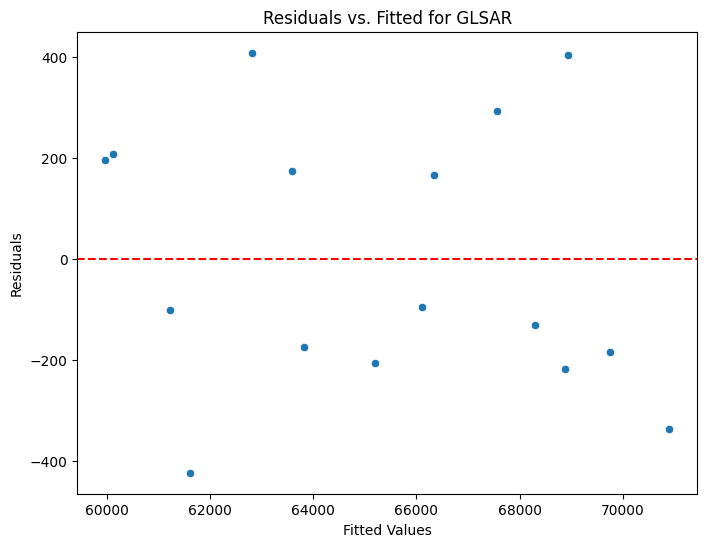

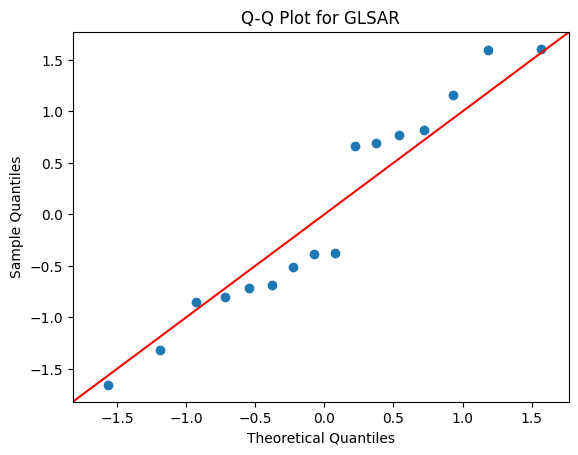

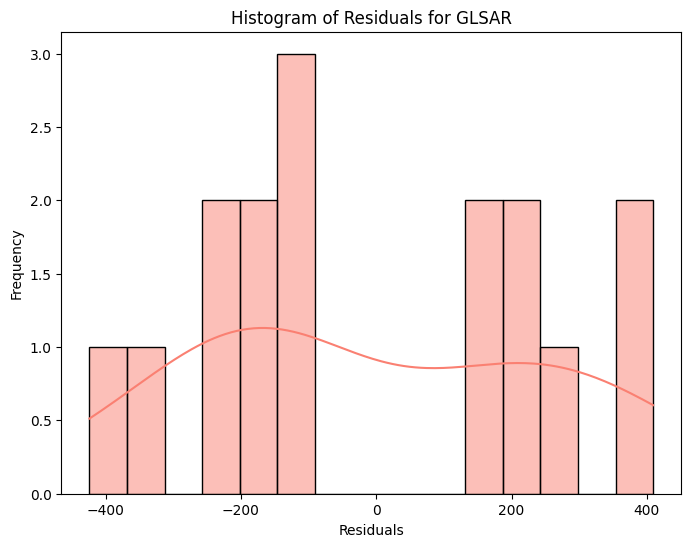

In [18]:
# Perform diagnostics for each model
models = {
    'OLS': ols_model,
    'WLS': wls_model,
    'GLS': gls_model,
    'FGLS': fgls_results,
    'GLSAR': glsar_results
}

for name, model in models.items():
    print(f"=== Residual Diagnostics for {name} ===")
    plot_residuals(model, name)
    print("\n\n\n")

In [19]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize dictionaries to store metrics
cv_metrics = {
    'Model': [],
    'Fold': [],
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'R2': []
}

In [20]:
def fit_ols(train_X, train_y):
    model = sm.OLS(train_y, train_X).fit()
    return model

def fit_wls(train_X, train_y):
    ols = sm.OLS(train_y, train_X).fit()
    weights = 1 / (ols.resid ** 2 + 1e-6)
    model = sm.WLS(train_y, train_X, weights=weights).fit()
    return model

def fit_gls(train_X, train_y, rho=0.5):
    n_train = len(train_y)
    order = np.abs(np.subtract.outer(np.arange(n_train), np.arange(n_train)))
    sigma = rho ** order
    model = sm.GLS(train_y, train_X, sigma=sigma).fit()
    return model

def fit_fgls(train_X, train_y, iterations=5):
    model = sm.OLS(train_y, train_X).fit()
    n_train = len(train_y)
    for _ in range(iterations):
        resid = model.resid
        resid_lagged = sm.add_constant(resid.shift(1).dropna())
        resid_current = resid.iloc[1:]
        resid_fit = sm.OLS(resid_current, resid_lagged).fit()
        # Access rho_est using .iloc
        rho_est = resid_fit.params.iloc[1]
        # Constrain rho_est within (-0.99, 0.99) to ensure positive definiteness
        rho_est = max(min(rho_est, 0.99), -0.99)
        # Construct covariance matrix assuming AR(1) structure
        sigma = rho_est ** np.abs(np.subtract.outer(np.arange(n_train), np.arange(n_train)))
        # Fit GLS model with the estimated covariance matrix
        model = sm.GLS(train_y, train_X, sigma=sigma).fit()
    return model

def fit_glsar(train_X, train_y):
    model = sm.GLSAR(train_y, train_X, rho=1)
    glsar_fit = model.iterative_fit(maxiter=10)
    return glsar_fit

In [21]:
# Define models to include in cross-validation
model_functions = {
    'OLS': fit_ols,
    'WLS': fit_wls,
    'GLS': fit_gls,
    'FGLS': fit_fgls,
    'GLSAR': fit_glsar
}

# Iterate over folds
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]

    for model_name, model_func in model_functions.items():
        try:
            # Fit the model
            if model_name == 'GLS':
                model_fit = model_func(train_X, train_y, rho=0.5)  # Using fixed rho for simplicity
            else:
                model_fit = model_func(train_X, train_y)

            # Predict on test set
            if model_name != 'GLSAR':
                y_pred = model_fit.predict(test_X)
            else:
                y_pred = model_fit.predict(test_X)

            # Compute metrics
            mse = mean_squared_error(test_y, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(test_y, y_pred)
            r2 = r2_score(test_y, y_pred)

            # Store metrics
            cv_metrics['Model'].append(model_name)
            cv_metrics['Fold'].append(fold + 1)
            cv_metrics['MSE'].append(mse)
            cv_metrics['RMSE'].append(rmse)
            cv_metrics['MAE'].append(mae)
            cv_metrics['R2'].append(r2)
        except Exception as e:
            print(f"Error in model {model_name} on fold {fold + 1}: {e}")

In [22]:
# Convert to DataFrame
cv_metrics_df = pd.DataFrame(cv_metrics)

print("Cross-Validated Predictive Metrics:")
display(cv_metrics_df)

Cross-Validated Predictive Metrics:


,Model,Fold,MSE,RMSE,MAE,R2
0,OLS,1,176931.891786,420.632728,327.842563,0.986686
1,WLS,1,183260.411073,428.089256,310.882391,0.986210
2,GLS,1,180934.643022,425.364130,345.390410,0.986385
3,FGLS,1,294378.761474,542.566827,516.920224,0.977848
4,GLSAR,1,289745.097156,538.279757,513.042439,0.978197
5,OLS,2,454981.701221,674.523314,627.822952,0.891444
6,WLS,2,345957.834061,588.181804,532.482699,0.917456
7,GLS,2,249960.622489,499.960621,459.653199,0.940361
8,FGLS,2,966657.555916,983.187447,936.830991,0.769361
9,GLSAR,2,957821.781249,978.683698,932.046240,0.771469


In [23]:
# Calculate average and standard deviation of metrics for each model
metrics_summary = cv_metrics_df.groupby('Model').agg({
    'MSE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'MAE': ['mean', 'std'],
    'R2': ['mean', 'std']
}).reset_index()

# Flatten MultiIndex columns
metrics_summary.columns = [
    'Model',
    'MSE_Mean', 'MSE_Std',
    'RMSE_Mean', 'RMSE_Std',
    'MAE_Mean', 'MAE_Std',
    'R2_Mean', 'R2_Std'
]

print("Summary of Cross-Validated Predictive Metrics:")
display(metrics_summary)

Summary of Cross-Validated Predictive Metrics:


,Model,MSE_Mean,MSE_Std,RMSE_Mean,RMSE_Std,MAE_Mean,MAE_Std,R2_Mean,R2_Std
0,FGLS,391398.492570,341507.861956,580.177553,261.707135,546.290154,251.361014,0.921051,0.093968
1,GLS,265407.507376,185601.282315,495.102086,159.222454,448.138330,154.093814,0.941707,0.065846
2,GLSAR,394811.317283,336993.496111,582.634375,263.031610,551.632730,249.035855,0.921062,0.093392
3,OLS,274191.826709,175809.865669,501.205764,169.501507,448.815259,174.311789,0.941696,0.059571
4,WLS,237481.988370,138909.337676,470.601888,141.491391,411.348750,143.528804,0.949650,0.049706


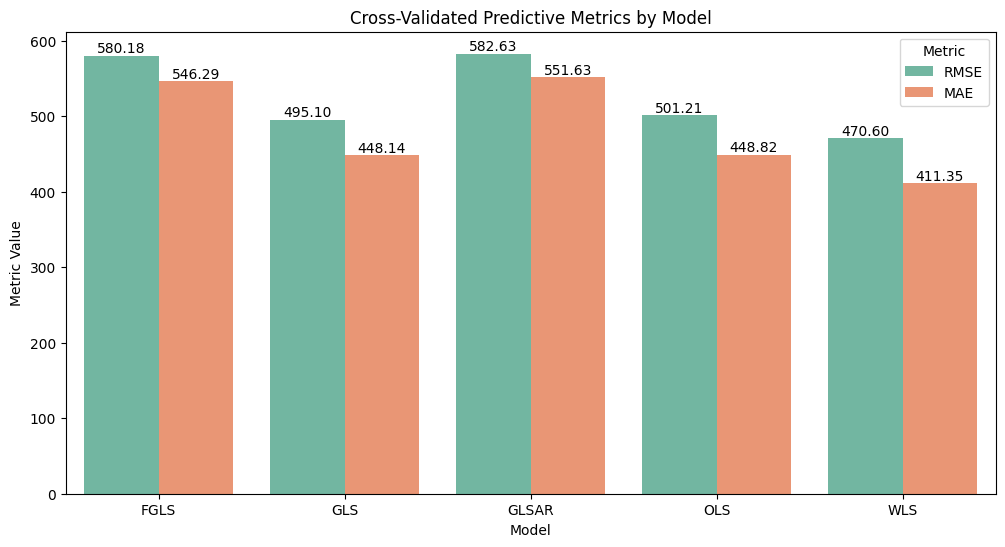

In [24]:
# Melt the summary DataFrame
metrics_melted = metrics_summary.melt(id_vars='Model', value_vars=['RMSE_Mean', 'MAE_Mean'],
                                      var_name='Metric', value_name='Value')

# Create a mapping for metric labels
metric_labels = {
    'RMSE_Mean': 'RMSE',
    'MAE_Mean': 'MAE',
}

# Replace metric names with labels
metrics_melted['Metric'] = metrics_melted['Metric'].map(metric_labels)

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Create a barplot
sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_melted, palette='Set2')

# Add title and labels
plt.title('Cross-Validated Predictive Metrics by Model')
plt.ylabel('Metric Value')
plt.xlabel('Model')

# Annotate bar plots with metric values
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.annotate(f'{height:.2f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=10)

plt.legend(title='Metric')
plt.show()